In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pandas as pd
df = pd.read_csv("/content/UNBER-1k.csv")
df

,reel_id,UnsafeType,Visual texts
0,www.facebook.com/reel/1000188341415358,Safe,Me on my way to watch Oppenheimer After Berbie
1,www.facebook.com/reel/1006146964533997,Safe,NaN
2,www.facebook.com/reel/1007123741459823,Adult,বান্ধবী আমার লাগানির পিনিকে আছে Love in love
3,www.facebook.com/reel/1007420607202244,Safe,প্রত্যেকটা অফিসে এমন একজন কলিগ থাকবেই Laptop
4,www.facebook.com/reel/1008519870870927,Safe,হ্যালো শার্ক ট্যাঙ্ক বাংলাদেশ আই এম কামিং
...,...,...,...
1112,www.facebook.com/reel/946250977507282,Suicidal,কিছু কথা বাকি ছিল আর হয়তো কোনদিনও বলা হবে না
1113,www.facebook.com/reel/951238780033589,Suicidal,তোমাকে মন দিয়ে ভালোবাসতাম উপহার হিসাবে তোমার ক...
1114,www.facebook.com/reel/974520454682213,Suicidal,ওগো শুনছো একথা বলা মানুষটা আজ অন্য কারোর।
1115,www.facebook.com/reel/975204184253727,Suicidal,"মন দিয়ে ভালোবাসতে গেলাম, অবশেষে ধোকা পেলাম।"


In [4]:
df['UnsafeType'], uniques = pd.factorize(df['UnsafeType'])
uniques

Index(['Safe', 'Adult', 'Harmful', 'Suicidal'], dtype='object')

In [5]:
dir = "/content/drive/MyDrive/UNBER-1k/Extracted_Features"

In [6]:
X = []
y = []

In [7]:
reels = []

for file in os.listdir(dir):
    if file.endswith(".npy"):
        file_path = os.path.join(dir, file)
        features = np.load(file_path)
        file_path = file_path.replace(".npy", "")
        file_path = file_path.replace(".wav", "")
        file_path = file_path.replace("/content/drive/MyDrive/UNBER-1k/Extracted_Features/audio", "www.facebook.com/reel/")
        if file_path in df['reel_id'].values:
          index = df.index[df['reel_id'] == file_path].tolist()[0]
          unsafe_type = df.loc[index, 'UnsafeType']
          y.append(unsafe_type)
          X.append(features)

In [8]:
X = np.array(X, dtype=np.float32)

In [9]:
X.shape

(1111, 21160)

In [10]:
y = np.array(y)
y.shape

(1111,)

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [12]:
import numpy as np

combined = list(zip(X, y))

np.random.shuffle(combined)

X, y = zip(*combined)

X = np.array(X)
y = np.array(y)

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

In [14]:
vggish_model = hub.load("https://tfhub.dev/google/vggish/1")

In [15]:
def extract_vggish_features(features):
    spectrogram = features
    embeddings = vggish_model(spectrogram)
    return embeddings

In [16]:
X_train_emb = np.array([extract_vggish_features(x) for x in X_train])
X_test_emb = np.array([extract_vggish_features(x) for x in X_test])
X_val_emb = np.array([extract_vggish_features(x) for x in X_val])

In [17]:
X_train_emb = X_train_emb.reshape(X_train_emb.shape[0], -1)
X_test_emb = X_test_emb.reshape(X_test_emb.shape[0], -1)
X_val_emb = X_val_emb.reshape(X_val_emb.shape[0], -1)

In [18]:
classifier = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(X_train_emb.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dense(4, activation="softmax")  # 4-class classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
classifier.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [21]:
classifier.fit(
    X_train_emb, y_train,
    epochs=200,
    batch_size=16,
    validation_data=(X_val_emb, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3367 - loss: 1.3417 - val_accuracy: 0.3708 - val_loss: 1.2892 - learning_rate: 5.0000e-04
Epoch 2/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4212 - loss: 1.2761 - val_accuracy: 0.3989 - val_loss: 1.2847 - learning_rate: 5.0000e-04
Epoch 3/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3968 - loss: 1.2764 - val_accuracy: 0.4045 - val_loss: 1.2913 - learning_rate: 5.0000e-04
Epoch 4/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3681 - loss: 1.2914 - val_accuracy: 0.3989 - val_loss: 1.2886 - learning_rate: 5.0000e-04
Epoch 5/200
46/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4022 - loss: 1.2397
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4039 - loss: 1.2431 - val_accuracy: 0.3933 - val_loss: 1.2858 - learning_rate: 5.0000e-04
Epoch 6/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4248 - los

In [22]:
y_pred = classifier.predict(X_test_emb)
y_pred_classes = np.argmax(y_pred, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step


In [23]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.42      0.89      0.57        18
           1       0.29      0.15      0.20        13
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         5

    accuracy                           0.40        45
   macro avg       0.18      0.26      0.19        45
weighted avg       0.25      0.40      0.29        45



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


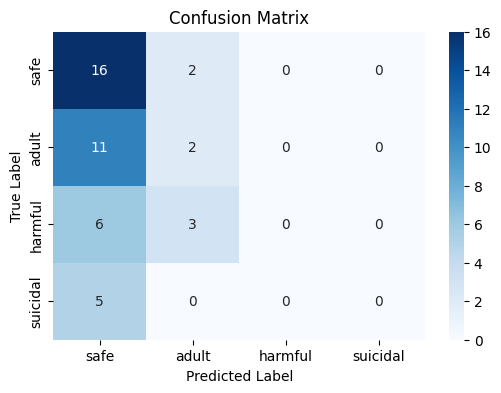

In [24]:
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["safe","adult","harmful","suicidal"], yticklabels=["safe","adult","harmful","suicidal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()